# Análisis de Redes Sociales, Práctica I
Paula Corral rebollar y Lucía Cuevas Serrano

# Datos y environment

## Funciones y librerias

In [8]:
#!pip install grakel --quiet
#!pip uninstall -y numpy --quiet
#!pip install numpy==1.26.4 --quiet

!pip install cdlib --quiet
!pip install leidenalg --quiet


In [9]:
import requests
import networkx as nx
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from cdlib.algorithms import leiden
import pandas as pd
from collections import defaultdict
from grakel.utils import graph_from_networkx
from grakel.kernels import WeisfeilerLehman, VertexHistogram
import matplotlib.colors as mcolors
from networkx.algorithms.community.quality import modularity
import matplotlib.ticker as mticker
import matplotlib.cm as cm


In [ ]:
# Formato de números
def format_number(n):
    if n >= 1_000_000:
        return f"{n/1_000_000:.1f}M"
    elif n >= 1_000:
        return f"{n/1_000:.1f}k"
    else:
        return str(int(n))

# Tweets por nodo
def node_total_weight(G, node):
    return sum(float(attr.get("weight", 0)) for _, _, attr in G.edges(node, data=True))

# Obtener un subgrafo de un grafo, un nodo y un número de vecinos
def subgrafo_vecinos(G, node, n_neighbors):
    neighbors = sorted(G[node].items(), key=lambda x: float(x[1].get("weight",0)), reverse=True)
    top_neighbors = [n for n, attr in neighbors[:n_neighbors]]
    return G.subgraph([node] + top_neighbors)

# Pasar de hex a rgb
def hex_a_rgb(h):
    h = h.lstrip("#")
    return tuple(int(h[i:i+2],16)/255 for i in (0,2,4))

# Obtener los colores de aristas en función a sus tweets 
def colorear_aristas(G, min_gray="#cccccc", max_gray="#222222"):
    rgb_min = hex_a_rgb(min_gray)
    rgb_max = hex_a_rgb(max_gray)
    weights = [float(G[u][v].get("weight",1)) for u,v in G.edges()]
    max_weight = max(weights)
    edge_colors = []
    for w in weights:
        t = w / max_weight
        r = rgb_min[0] + t*(rgb_max[0]-rgb_min[0])
        g = rgb_min[1] + t*(rgb_max[1]-rgb_min[1])
        b = rgb_min[2] + t*(rgb_max[2]-rgb_min[2])
        edge_colors.append((r,g,b))
    return edge_colors

# Obtener tamaño de aristas
def tamaño_aristas(G, min_width=0.5, max_width=5):
    weights = [float(G[u][v].get("weight", 1)) for u, v in G.edges()]
    if not weights:
        return []
    min_w = min(weights)
    max_w = max(weights)
    if max_w == min_w:
        return [0.5 * (min_width + max_width) for _ in weights]
    edge_widths = [
        min_width + (w - min_w) / (max_w - min_w) * (max_width - min_width)
        for w in weights
    ]
    return edge_widths

# Colorear nodos según sus tweets
def colorear_nodos(G, palette, min_weight=None, max_weight=None):
    weights = [node_total_weight(G, node) for node in G.nodes()]
    if min_weight is None:
        min_weight = min(weights)
    if max_weight is None:
        max_weight = max(weights)
    if max_weight == min_weight:
        norm_weights = [0.5 for _ in weights]
    else:
        norm_weights = [(w - min_weight) / (max_weight - min_weight) for w in weights]
    palette_rgb = [hex_a_rgb(c) for c in palette]
    n_colors = len(palette_rgb)
    node_colors = []
    for t in norm_weights:
        idx = int(t * (n_colors - 1))
        node_colors.append(palette_rgb[idx])
    return node_colors

# Obtener el tamaño de los nodos según sus tweets
def tamaño_nodos(G, min_size=300, max_size=1000):
    weights = [node_total_weight(G, node) for node in G.nodes()]
    min_w = min(weights)
    max_w = max(weights)
    if max_w == min_w:  
        norm_weights = [0.5 for _ in weights]  
    else:
        norm_weights = [(w - min_w) / (max_w - min_w) for w in weights]
    sizes = [min_size + t * (max_size - min_size) for t in norm_weights]
    return sizes

# Dibujar un subgrafo a partir de un nodo
def dibujar_subgrafo(subG, central_node, pos=None, node_sizes=None):
    import matplotlib.pyplot as plt
    if pos is None:
        pos = nx.spring_layout(subG, seed=42)
    node_colors = ["gold" if n == central_node else "skyblue" for n in subG.nodes()]
    if node_sizes is None:
        node_sizes=500
    nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=node_sizes)
    nx.draw_networkx_edges(subG, pos, width=2, edge_color=colorear_aristas(subG))
    nx.draw_networkx_labels(subG, pos, font_size=10)
    plt.title(f"Grafo a partir de {central_node} con {len(subG.nodes())-1} vecinos")
    plt.axis('off')

# Plotear info de comunidades desde un df
def plot_comunidades_df(df, top_n_nodes=5, minimum_tweets_color=0):

    cols = 7
    rows = int(np.ceil(len(df) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
    if rows == 1:
        axes = np.array([axes])

    # Rangos para colores
    sizes = df["num_nodes"].tolist()
    min_size, max_size = min(sizes), max(sizes)

    for plot_idx, (_, row) in enumerate(df.iterrows()):
        row_idx = plot_idx // cols
        col_idx = plot_idx % cols
        ax = axes[row_idx, col_idx] if rows > 1 else axes[col_idx]

        # Color según tamaño
        if row["total_tweets"] < minimum_tweets_color:
            color = (0.7, 0.7, 0.7)
        else:
            t = (row["num_nodes"] - min_size) / (max_size - min_size + 1e-6)
            color = (t, 1-t, 0)

        ax.add_patch(plt.Rectangle((0,0),1,1,color=color))

        # Top N nodos
        top_nodes_text = "\n".join(row["top_10_nodes"][:top_n_nodes])
        ax.text(0.5, 0.4, top_nodes_text, ha="center", va="center", fontsize=17)
        ax.text(0.5, 0.95, f"{row['num_nodes']} nodos", ha="center", va="top", fontsize=19, fontweight='bold')

        total_tweets_k = row["total_tweets"] / 1000
        ax.text(0.5, 0.85, f"{total_tweets_k:.1f}k tweets", ha="center", va="top", fontsize=19)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)

    total_slots = rows * cols
    for j in range(len(df), total_slots):
        row_idx = j // cols
        col_idx = j % cols
        ax = axes[row_idx, col_idx] if rows > 1 else axes[col_idx]
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Plot del grafo para mostrar centralidad
def plot_centralidad(G_coms, columna, shell_threshold, print_threshold):

    shells = [
        [n for n in G_coms if G_coms.nodes[n][columna] > shell_threshold],
        [n for n in G_coms if G_coms.nodes[n][columna] <= shell_threshold]
    ]

    pos = nx.shell_layout(G_coms, shells)

    # Tamaño de nodos según centrality
    deg_values = [G_coms.nodes[n][columna] for n in G_coms.nodes()]
    min_size, max_size = 10, 1000
    if max(deg_values) == min(deg_values):
        node_sizes = [0.5*(min_size+max_size) for _ in deg_values]
    else:
        node_sizes = [min_size + (v - min(deg_values)) / (max(deg_values)-min(deg_values))*(max_size-min_size)
                    for v in deg_values]

    # Colores de nodos según peso total de la comunidad
    weights = [node_total_weight(G_coms, n) for n in G_coms.nodes()]
    norm = mcolors.Normalize(vmin=min(deg_values), vmax=max(deg_values))
    cmap = plt.cm.RdYlGn_r
    node_colors = [cmap(norm(w)) for w in deg_values]

    # Anchura de aristas
    edge_widths = tamaño_aristas(G_coms, min_width=0.1, max_width=2)

    # Nodos
    nx.draw_networkx_nodes(G_coms, pos, node_size=node_sizes, node_color=node_colors, alpha=0.85)

    # Aristas
    nx.draw_networkx_edges(G_coms, pos, width=edge_widths, alpha=0.5)

    # Id nodo
    nx.draw_networkx_labels(G_coms, pos, labels={n: n for n in G_coms.nodes}, font_size=10, font_weight="bold")

    # Imprimir 4 top nodos si centrality > print_threshold
    ys = [y for x, y in pos.values()]
    y_median = sum(ys) / len(ys)
    for n, (x, y) in pos.items():
        if G_coms.nodes[n][columna] <= print_threshold:
            continue
        top4 = G_coms.nodes[n].get("top_10_nodes", [])[:4]
        if not top4:
            continue
        lines = [", ".join(top4[i:i+2]) for i in range(0, len(top4), 2)]
        text = "\n".join(lines)
        if y > y_median:
            va, offset = "bottom", 0.08 
        else:
            va, offset = "top", -0.08
        plt.text(x, y + offset, text, fontsize=6, alpha=0.8, ha="center", va=va)

    plt.axis("off")
    plt.tight_layout()

# Barplot de los valores de centralidad
def barplot_centralidad(G, metric):
    values = nx.get_node_attributes(G, metric)

    df = (
        pd.DataFrame.from_dict(values, orient='index', columns=[metric])
        .sort_values(metric, ascending=False)
    )

    vals = df[metric].values
    norm = mcolors.Normalize(vmin=min(vals), vmax=max(vals))
    cmap = plt.cm.RdYlGn_r
    colors = [cmap(norm(v)) for v in vals]

    plt.barh(df.index.astype(str), vals, color=colors)
    plt.gca().invert_yaxis()

    plt.title(metric.replace("_", " ").title())
    plt.xlabel("Centralidad")
    plt.ylabel("Comunidad")

# Combinación del barplot y el plot de centralidad
def grafica_centralidad(G_coms, columna, shell_threshold, print_threshold):
    fig, axes = plt.subplots(
        1, 2,
        figsize=(7, 5),
        gridspec_kw={"width_ratios": [1, 2]}
    )

    plt.sca(axes[0])
    barplot_centralidad(G_coms, columna)

    plt.sca(axes[1])
    plot_centralidad(G_coms, columna, shell_threshold, print_threshold)

    plt.tight_layout()
    plt.show()


## Cargar datos

Cargamos los datos directamente del archivo en github y lo abrimos como un grafo usando NetworkX.

In [11]:
# Descargar archivo
response = requests.get("https://raw.githubusercontent.com/luciacuevascsv/analisis_redes_sociales/main/Practica%20I/hashtags_cleaned.graphml")
response.raise_for_status()

# Cargar grafo
file_like = BytesIO(response.content)
G = nx.read_graphml(file_like)
print("Número de nodos:", G.number_of_nodes())
print("Número de aristas:", G.number_of_edges())


Número de nodos: 47544
Número de aristas: 536124


## Visualizar datos

Seguimos los resultados mostrados en [Campaign 2020 on Twitter: Top Names and Hashtags by Mention Volume de The George Washington University](https://gspm.gwu.edu/sites/g/files/zaxdzs5061/files/downloads/Campaign%202020%20on%20Twitter.pdf) mostrados a continuación para ver subgrafos basados en hashtags populares de ambos partidos (Republicano en la primera fila y Demócrata en la segunda).

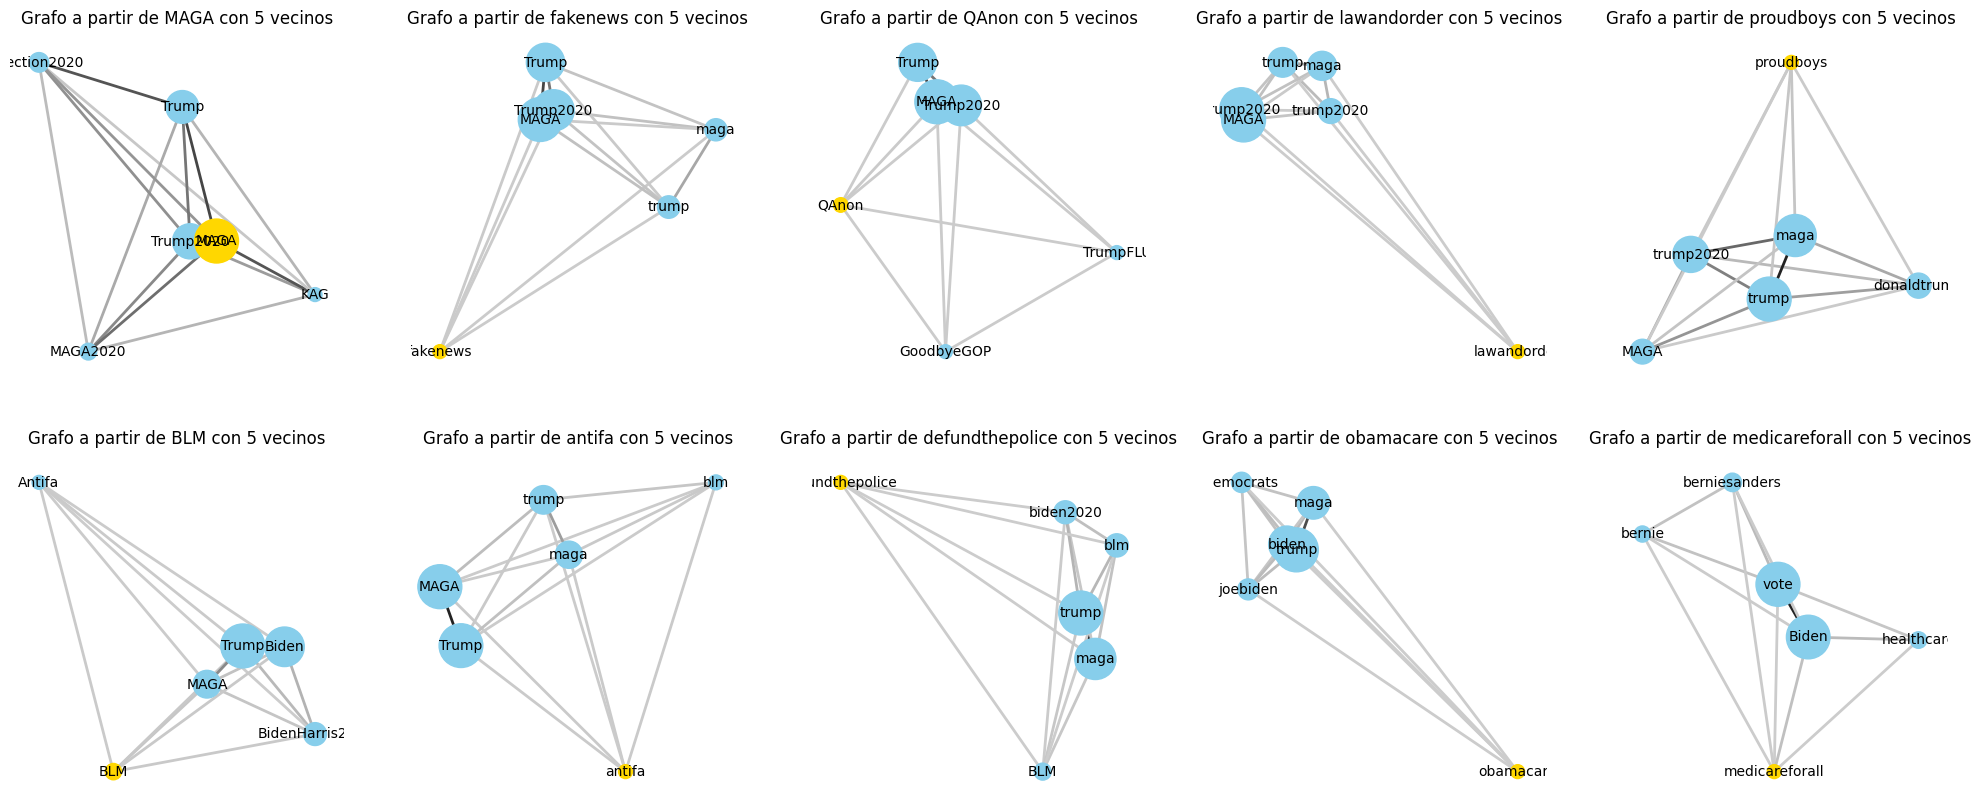

In [12]:
hashtags = [
    "MAGA", "fakenews", "QAnon", "lawandorder", "proudboys",
    "BLM", "antifa", "defundthepolice", "obamacare", "medicareforall"
]

fig, axes = plt.subplots(2, 5, figsize=(25, 10))  

for ax, hashtag in zip(axes.flatten(), hashtags):
    plt.sca(ax)
    subG = subgrafo_vecinos(G, hashtag, 5)
    node_sizes = tamaño_nodos(subG, min_size=100, max_size=1000)
    dibujar_subgrafo(subG, hashtag, node_sizes=node_sizes)


# Ejercicios

## 1. Calcula las comunidades utilizando el algoritmo de Leiden. ¿Cuántas comunidades salen? 

En la siguiente celda aplicamos Leiden y sacamos el número de comunidades. Haciendo varias iteraciones obtenemos números distintos, ya que se generan muchas comunidades con pocos nodos (y pocos tweets). Hacemos un loop en el que se aplica Leiden hasta obtener un número adecuado de comunidades. En este ejemplo en concreto obtenemos **(COMPLETAR)** comunidades.

In [13]:
num_communities=1000
num_iteraciones=0
lowest_num_communities=1000
list_communities_mod=[]

while num_communities>35 and num_iteraciones<=20: 
    # Restrinjo el número de nodos para que no haya mucho ruido de comunidades con pocos nodos (y no filtrarlos después)
    communities = leiden(G)
    list_communities_mod.append(communities)
    num_communities = len(communities.communities)
    if num_communities<lowest_num_communities:
        lowest_num_communities=num_communities
        communities_save=communities
    num_iteraciones+=1
    print(f"Iteración {num_iteraciones}: {num_communities} comunidades.")

if num_communities>35:
    communities=communities_save
    num_communities=lowest_num_communities

print("Número de comunidades detectadas:", num_communities)


Iteración 1: 58 comunidades.
Iteración 2: 58 comunidades.
Iteración 3: 52 comunidades.
Iteración 4: 58 comunidades.
Iteración 5: 48 comunidades.
Iteración 6: 65 comunidades.
Iteración 7: 81 comunidades.
Iteración 8: 41 comunidades.
Iteración 9: 65 comunidades.
Iteración 10: 40 comunidades.
Iteración 11: 29 comunidades.
Número de comunidades detectadas: 29


In [14]:
# Asignar comunidad a cada nodo
nx.set_node_attributes(G, None, "community")
for community_id, nodes in enumerate(communities.communities):
    for node in nodes:
        G.nodes[node]["community"] = community_id

Y a continuación mostramos las comunidades resultantes, representadas por sus 6 nodos con mayor weight combinado (mayor número de tweets que incluyen esos hashtags). Podemos ver que se han generado comunidades pequeñas con pocos nodos y consecuentemente pocos tweets (hemos pintado las comunidades con menos de 1000 tweets en gris en la imagen). Vamos a mantenerlos en el análisis de los siguientes apartados para estudiar el grafo original al completo, aunque la información de estas comunidades es prácticamente nula en comparación con los tweets de comunidades con más nodos. 

In [15]:
# Agrupar nodos por comunidad
communities_dict = defaultdict(list)
for node, data in G.nodes(data=True):
    comm = data.get("community")
    if comm is not None:
        communities_dict[comm].append(node)

# Calcular todos los pesos de nodos
all_node_weights = {node: node_total_weight(G, node) for node in G.nodes()}

# Crear df
community_rows = [
    {
        "community_id": community_id,
        "num_nodes": len(nodes),
        "total_tweets": int(sum(all_node_weights[n] for n in nodes)),
        "top_10_nodes": [
            node for node, _ in sorted(
                ((n, all_node_weights[n]) for n in nodes),
                key=lambda x: x[1],
                reverse=True
            )[:10]
        ]
    }
    for community_id, nodes in sorted(communities_dict.items())
]

community_df = pd.DataFrame(community_rows)
pd.set_option("display.max_colwidth", None)
community_df.reset_index(drop=True, inplace=True)


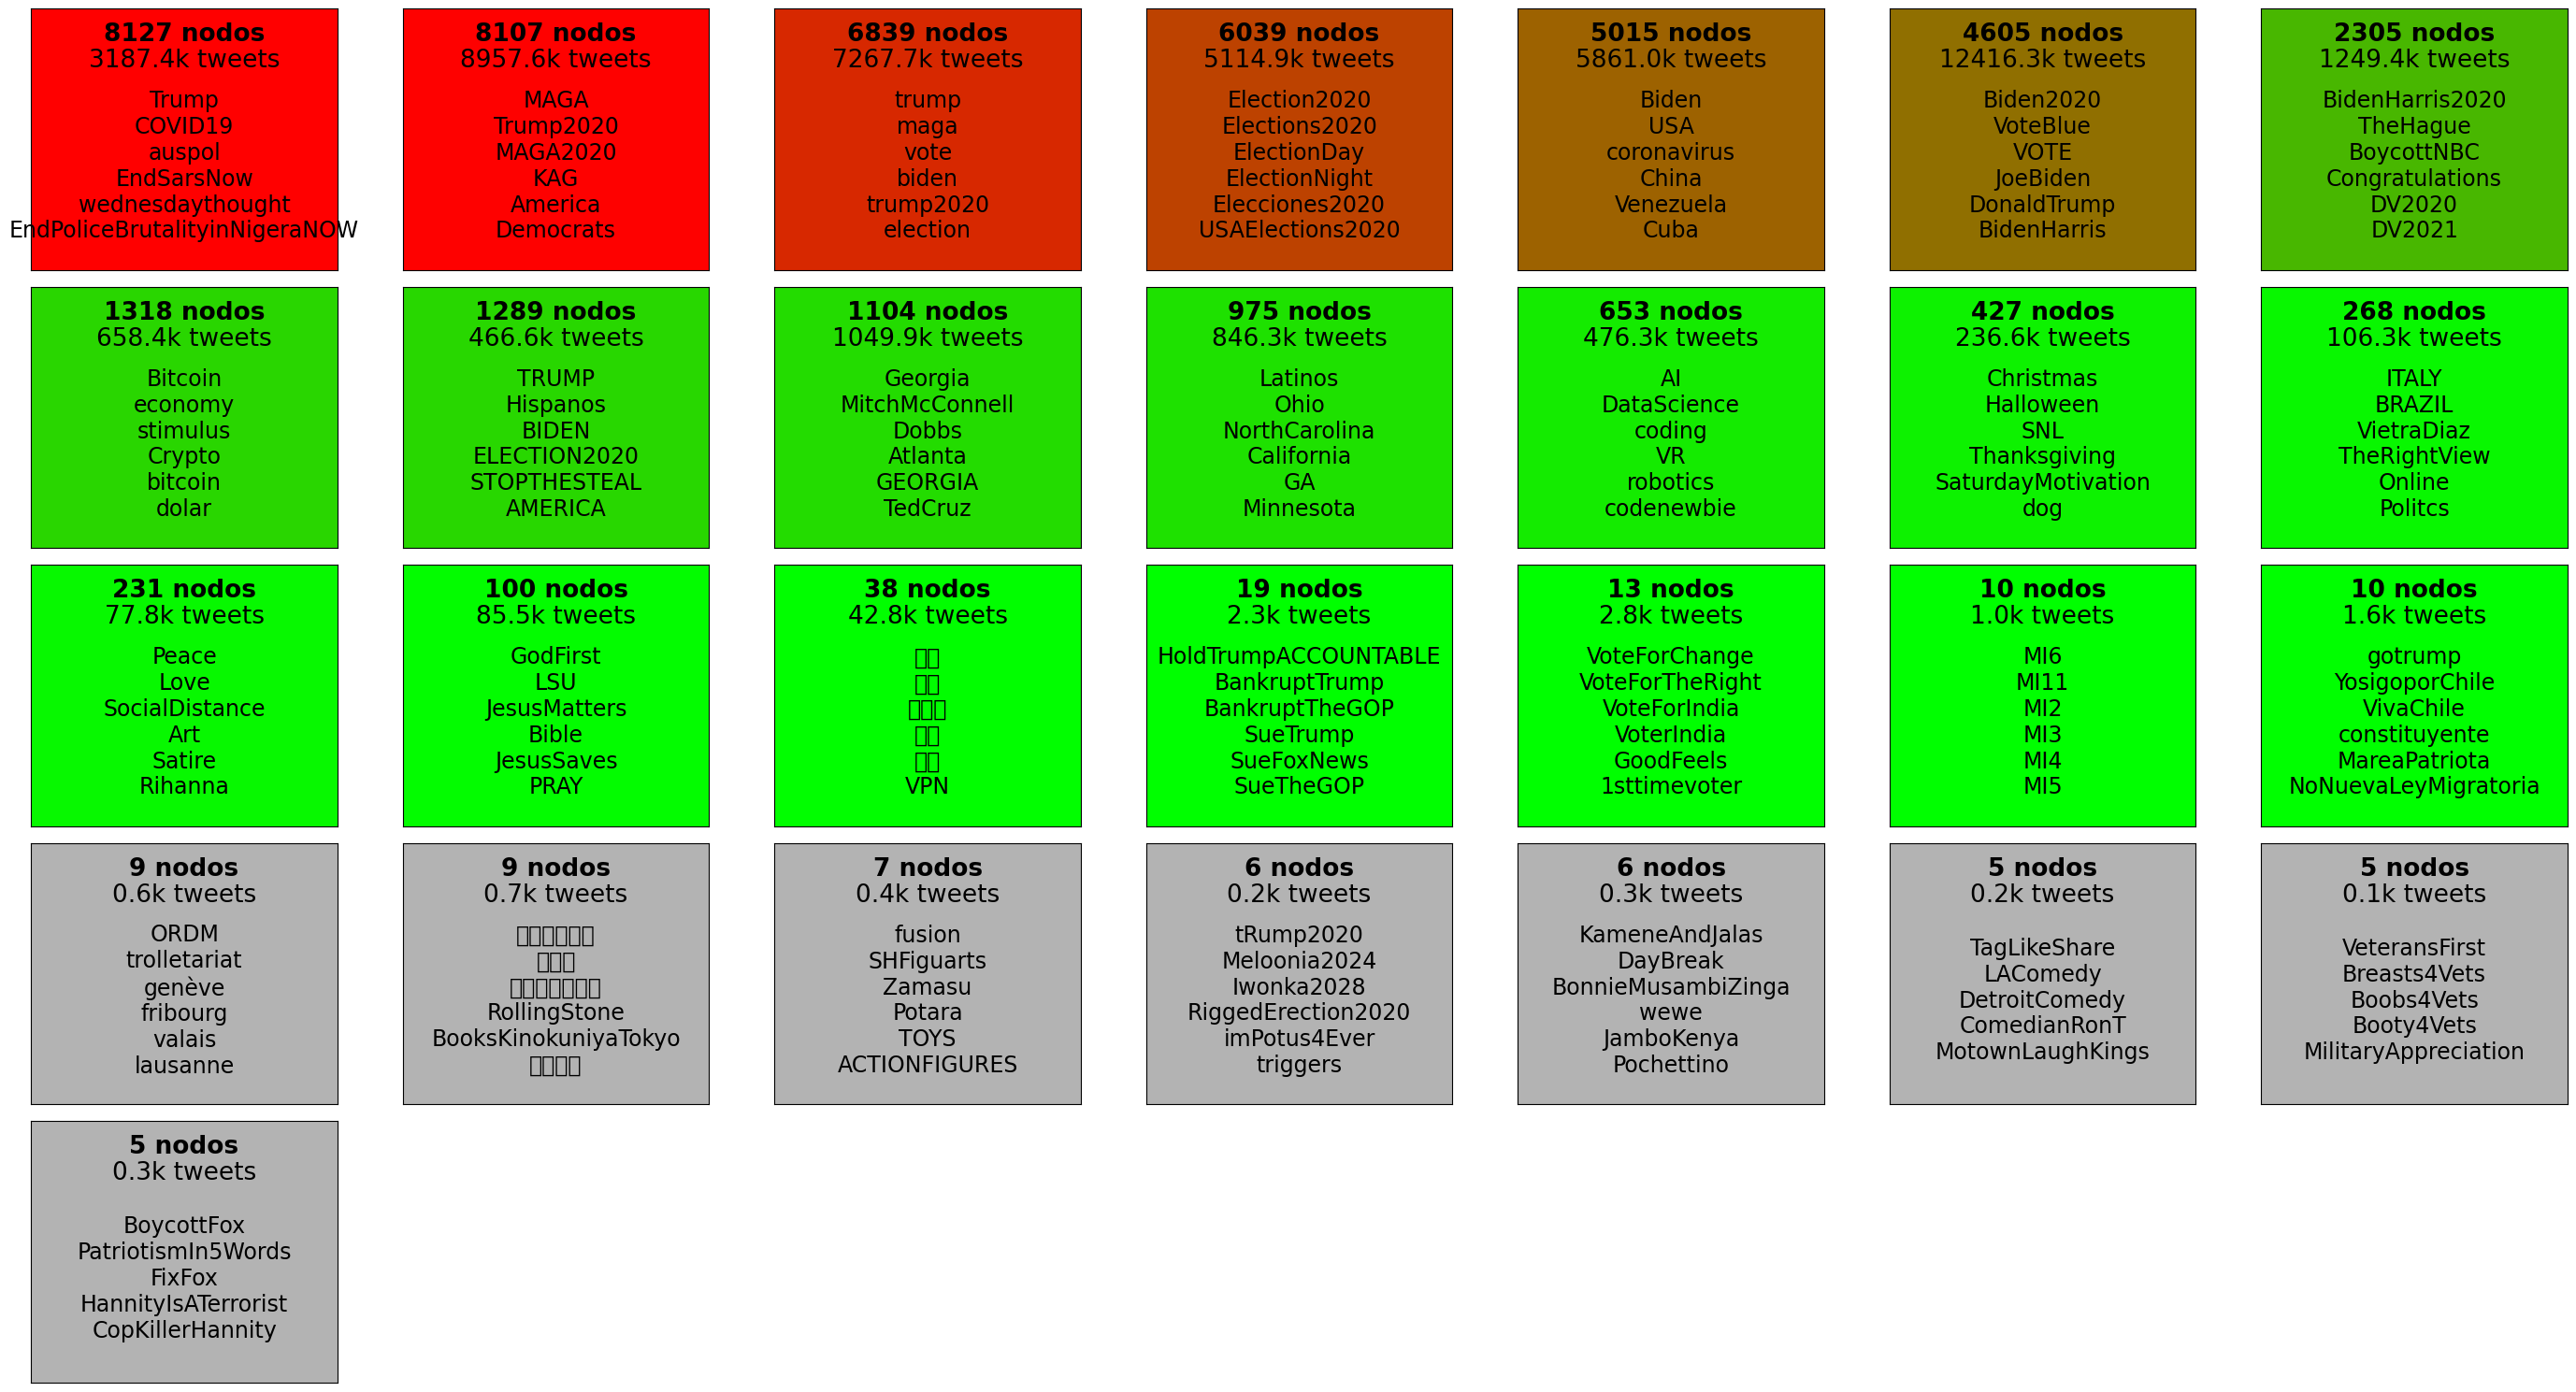

In [16]:
plot_comunidades_df(community_df, top_n_nodes=6, minimum_tweets_color=1000)

## 2. Utiliza Weisfeiler-lehmangraph kernels para codificar cada una de las comunidades como si de grafos independientes se trataran. Basado en los resultados obtenidos, ¿qué comunidades son más similares? 


In [17]:
# Subgrafos
subgraphs = [G.subgraph(communities.communities[i]).copy() for i in range(num_communities)]
grakel_graphs = graph_from_networkx(subgraphs, val_node_labels='0')

# Crear el kernel WL
wl = WeisfeilerLehman(n_iter=3, normalize=True, base_graph_kernel=VertexHistogram)
K = wl.fit_transform(grakel_graphs)

# Eliminar diagonal y triangulo inferior
K_no_diag = K.copy()
np.fill_diagonal(K_no_diag, 0)
K_unique = K_no_diag.copy()
K_unique[np.tril_indices_from(K_unique)] = 0

# Obtener los índices de las mayores similitudes
flat_indices = np.argsort(K_unique, axis=None)[-10:]
pairs = np.unravel_index(flat_indices, K_unique.shape)

Como podemos ver en la matriz, conforme el número de las comunidades avanza (las comunidades se hacen más pequeñas, menos nodos) se vuelven menos similares entre si, salvo que tengan el mismo número de nodos, como veremos en el siguiente código. Las primeras comunidades son en general más parecidas entre sí.

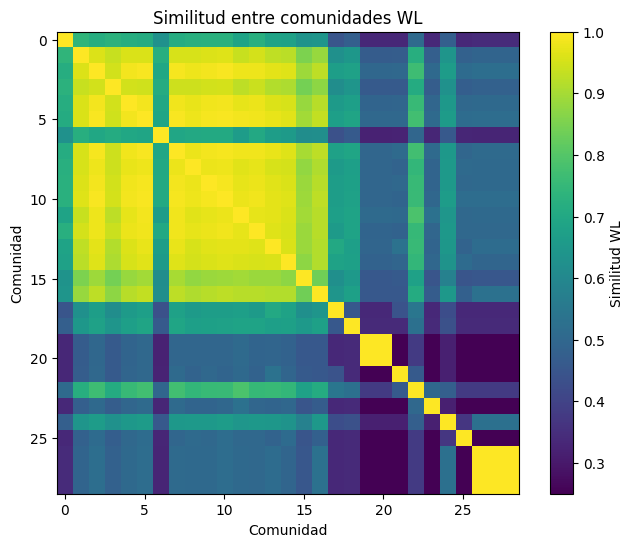

In [18]:
indices = np.unravel_index(
    np.argsort(K_no_diag, axis=None)[-3:],
    K_no_diag.shape
)

similarities = K_no_diag[indices]

# Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(K, cmap="viridis")
plt.colorbar(label="Similitud WL")
plt.title("Similitud entre comunidades WL")
plt.xlabel("Comunidad")
plt.ylabel("Comunidad")
plt.show()

En el siguiente código, que muestra las 10 parejas con mayor similitud, vemos las parejas de comunidades con similitud 1 (correspondientes a comunidades pequeñas) y las parejas con alta similitud, correspondientes a las comunidades con más nodos, que suelen tener en común que sus hashtags son generales y usados de manera masiva. 

In [19]:
K_temp = K_no_diag.copy()
K_temp[np.tril_indices_from(K_temp)] = 0

# 10 mayores similitudes
flat_indices = np.argsort(K_temp, axis=None)[-10:][::-1]
pairs = np.unravel_index(flat_indices, K_temp.shape)

for idx in range(len(flat_indices)):
    i, j = pairs[0][idx], pairs[1][idx]
    simil = K_temp[i, j]
    
    # Información de cada comunidad
    comm_i = community_df.iloc[i]
    comm_j = community_df.iloc[j]
    
    print(f"\nSimilitud: {simil:.4f} entre comunidad {i} y comunidad {j}")
    print(f"Comunidad {i}: {comm_i['num_nodes']} nodos, {int(comm_i['total_tweets'])} tweets -> " +
          ", ".join(comm_i['top_10_nodes'][:10]))
    print(f"Comunidad {j}: {comm_j['num_nodes']} nodos, {int(comm_j['total_tweets'])} tweets -> " +
          ", ".join(comm_j['top_10_nodes'][:10]))
    


Similitud: 1.0000 entre comunidad 19 y comunidad 20
Comunidad 19: 10 nodos, 1006 tweets -> MI6, MI11, MI2, MI3, MI4, MI5, MI7, MI8, MI9, MI10
Comunidad 20: 10 nodos, 1642 tweets -> gotrump, YosigoporChile, VivaChile, constituyente, MareaPatriota, NoNuevaLeyMigratoria, NoLeyMordaza, BloquePatriota, NOMasONU, TwitterIsComunist

Similitud: 1.0000 entre comunidad 27 y comunidad 28
Comunidad 27: 5 nodos, 140 tweets -> VeteransFirst, Breasts4Vets, Boobs4Vets, Booty4Vets, MilitaryAppreciation
Comunidad 28: 5 nodos, 280 tweets -> BoycottFox, PatriotismIn5Words, FixFox, HannityIsATerrorist, CopKillerHannity

Similitud: 1.0000 entre comunidad 26 y comunidad 27
Comunidad 26: 5 nodos, 200 tweets -> TagLikeShare, LAComedy, DetroitComedy, ComedianRonT, MotownLaughKings
Comunidad 27: 5 nodos, 140 tweets -> VeteransFirst, Breasts4Vets, Boobs4Vets, Booty4Vets, MilitaryAppreciation

Similitud: 1.0000 entre comunidad 26 y comunidad 28
Comunidad 26: 5 nodos, 200 tweets -> TagLikeShare, LAComedy, DetroitC

## 3. El tamaño del grafo excede el tiempo que tenemos en la práctica, por ello, y para tener una representación más compacta, colapsa el grafo de forma que cada nodo sea una comunidad, manteniendo los atributos. 


Colapsamos las comunidades en nodos asignandoles el número de comunidad, el número de nodos y el número de tweets, y calculamos el peso como la suma de los tweets interconectados entre comunidades con los weights individuales de cada nodo que forma parte de ellas. 

In [20]:
# Agrupar nodos por comunidad
communities_dict = defaultdict(list)
for n, data in G.nodes(data=True):
    communities_dict[data["community"]].append(n)

# Calcular los tweets de cada nodo
node_strengths = {n: sum(float(G[n][nbr].get("weight", 1)) for nbr in G[n]) for n in G.nodes()}

# Construir grafo de comunidades
G_coms = nx.Graph()

# Añadir nodos de comunidades con atributos
for cid, nodes in communities_dict.items():
    strengths = {n: node_strengths[n] for n in nodes}
    G_coms.add_node(
        cid,
        size=len(nodes),
        num_tweets=sum(strengths.values()),
        top_10_nodes=sorted(strengths, key=strengths.get, reverse=True)[:10]
    )

# Calcular aristas
edge_weights = defaultdict(float)
for u, v, data in G.edges(data=True):
    cu, cv = G.nodes[u]["community"], G.nodes[v]["community"]
    if cu != cv:
        # Quitar duplicados
        key = tuple(sorted((cu, cv)))
        edge_weights[key] += float(data.get("weight", 1))
for (cu, cv), w in edge_weights.items():
    G_coms.add_edge(cu, cv, weight=w)


In [21]:
print("Nodos originales:", G.number_of_nodes())
print("Nodos colapsados:", G_coms.number_of_nodes())

Nodos originales: 47544
Nodos colapsados: 29


In [22]:
top_nodes = sorted(G_coms.nodes(data=True), key=lambda x: x[1]["size"], reverse=True)[:3]

for idx, (node_id, attrs) in enumerate(top_nodes):
    print(f"Comunidad {node_id}: {attrs['size']} nodos, {int(attrs['num_tweets'])} tweets")
    print(f"{attrs['top_10_nodes']}\n")


Comunidad 0: 8127 nodos, 3187426 tweets
['Trump', 'COVID19', 'auspol', 'EndSarsNow', 'wednesdaythought', 'EndPoliceBrutalityinNigeraNOW', 'humantraffickingawareness', 'HitRefresh', 'RbyPoll', 'FelizLunes']

Comunidad 1: 8107 nodos, 8957617 tweets
['MAGA', 'Trump2020', 'MAGA2020', 'KAG', 'America', 'Democrats', 'AmericaFirst', 'KAG2020', 'StopTheSteal', 'POTUS']

Comunidad 2: 6839 nodos, 7267683 tweets
['trump', 'maga', 'vote', 'biden', 'trump2020', 'election', 'election2020', 'covid', 'covid19', 'usa']



In [23]:
# Obtener los colores de aristas en función a sus tweets 
def colorear_aristas(G, min_gray="#cccccc", max_gray="#222222"):
    rgb_min = hex_a_rgb(min_gray)
    rgb_max = hex_a_rgb(max_gray)
    weights = [float(G[u][v].get("weight",1)) for u,v in G.edges()]
    max_weight = max(weights)
    edge_colors = []
    for w in weights:
        t = w / max_weight
        r = rgb_min[0] + t*(rgb_max[0]-rgb_min[0])
        g = rgb_min[1] + t*(rgb_max[1]-rgb_min[1])
        b = rgb_min[2] + t*(rgb_max[2]-rgb_min[2])
        edge_colors.append((r,g,b))
    return edge_colors

# Obtener tamaño de aristas
def tamaño_aristas(G, min_width=0.5, max_width=5):
    weights = [float(G[u][v].get("weight", 1)) for u, v in G.edges()]
    if not weights:
        return []
    min_w = min(weights)
    max_w = max(weights)
    if max_w == min_w:
        return [0.5 * (min_width + max_width) for _ in weights]
    edge_widths = [
        min_width + (w - min_w) / (max_w - min_w) * (max_width - min_width)
        for w in weights
    ]
    return edge_widths

# Colorear nodos según sus tweets
def colorear_nodos(G, palette, min_weight=None, max_weight=None):
    weights = [node_total_weight(G, node) for node in G.nodes()]
    if min_weight is None:
        min_weight = min(weights)
    if max_weight is None:
        max_weight = max(weights)
    if max_weight == min_weight:
        norm_weights = [0.5 for _ in weights]
    else:
        norm_weights = [(w - min_weight) / (max_weight - min_weight) for w in weights]
    palette_rgb = [hex_a_rgb(c) for c in palette]
    n_colors = len(palette_rgb)
    node_colors = []
    for t in norm_weights:
        idx = int(t * (n_colors - 1))
        node_colors.append(palette_rgb[idx])
    return node_colors

# Obtener el tamaño de los nodos según sus tweets
def tamaño_nodos(G, min_size=300, max_size=1000):
    weights = [node_total_weight(G, node) for node in G.nodes()]
    min_w = min(weights)
    max_w = max(weights)
    if max_w == min_w:  
        norm_weights = [0.5 for _ in weights]  
    else:
        norm_weights = [(w - min_w) / (max_w - min_w) for w in weights]
    sizes = [min_size + t * (max_size - min_size) for t in norm_weights]
    return sizes



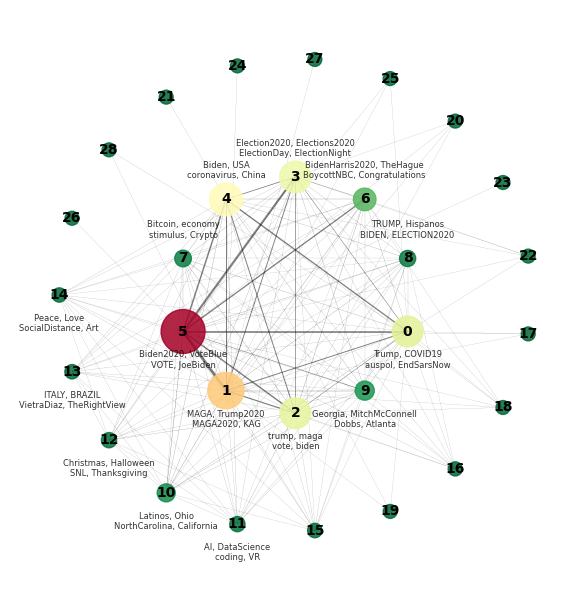

In [24]:
# Shell layout por tamaño de comunidad
shells = [
    [n for n in G_coms if G_coms.nodes[n]["size"] > 1000],
    [n for n in G_coms if G_coms.nodes[n]["size"] <= 1000]
]

# Elementos

pos = nx.shell_layout(G_coms, shells)
node_sizes = tamaño_nodos(G_coms, min_size=100, max_size=1000)
weights = [node_total_weight(G_coms, n) for n in G_coms.nodes()]
norm = mcolors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = plt.cm.RdYlGn_r
node_colors = [cmap(norm(w)) for w in weights]
edge_widths=tamaño_aristas(G_coms, min_width=0.1, max_width=2)

plt.figure(figsize=(6, 6))

# Nodos
nx.draw_networkx_nodes(
    G_coms, pos,
    node_size=node_sizes,
    node_color=node_colors,
    alpha=0.85
)

# Aristas
nx.draw_networkx_edges(
    G_coms, pos,
    width=edge_widths,
    alpha=0.5
)

# Id nodo
nx.draw_networkx_labels(
    G_coms,
    pos,
    labels={n: n for n in G_coms.nodes},
    font_size=10,
    font_weight="bold"
)

# Si size > 100 imprimir 4 top nodos
ys = [y for x, y in pos.values()]
y_median = sum(ys) / len(ys) 
for n, (x, y) in pos.items():
    if G_coms.nodes[n]["size"] <= 200:
        continue
    top4 = G_coms.nodes[n].get("top_10_nodes", [])[:4]
    if not top4:
        continue
    lines = [", ".join(top4[i:i+2]) for i in range(0, len(top4), 2)]
    text = "\n".join(lines)
    if y > y_median:
        va, offset = "bottom", 0.08 
    else:
        va, offset = "top", -0.08
    plt.text(x, y + offset, text,fontsize=6, alpha=0.8, ha="center", va=va)

plt.axis("off")
plt.tight_layout()
plt.show()


## 4. Aplica distintas métricas que puedan resultar útiles para tener una mejor idea de las comunidades, y crea visualizaciones diferentes en función de las métricas. 

### Modularidad

In [25]:
for u, v, data in G.edges(data=True):
    data["weight"] = float(data.get("weight", 1))
communities = {}
for n, data in G.nodes(data=True):
    cid = data["community"]
    communities.setdefault(cid, set()).add(n)
partition = list(communities.values())

Q = modularity(G, partition, weight="weight")

print(f"Modularidad de G: {Q:.4f}")


Modularidad de G: 0.3294



Dado que previamente hemos forzado un número determinado de comunidades para que saliese menos ruido, en la siguiente celda demostramos que para este grafo en concreto, su modularidad dadas distintas iteraciones de Leiden sin restringir el número de comunidades se mantienen en un valor similar al que tenemos.

In [26]:
for iteracion in range(len(list_communities_mod)):
    G_aux=G.copy()
    communities_aux = list_communities_mod[iteracion]
    for community_id, nodes in enumerate(communities_aux.communities):
        for node in nodes:
            G_aux.nodes[node]["community"] = community_id
    for u, v, data in G_aux.edges(data=True):
        data["weight"] = float(data.get("weight", 1))
    partition = [set(c) for c in communities_aux.communities]
    Q = modularity(G_aux, partition, weight="weight")
    print(f"Modularidad de G con {len(communities_aux.communities)} comunidades: {Q:.4f}")


Modularidad de G con 58 comunidades: 0.3691
Modularidad de G con 58 comunidades: 0.3677
Modularidad de G con 52 comunidades: 0.3717
Modularidad de G con 58 comunidades: 0.3658
Modularidad de G con 48 comunidades: 0.3014
Modularidad de G con 65 comunidades: 0.3558
Modularidad de G con 81 comunidades: 0.3092
Modularidad de G con 41 comunidades: 0.3271
Modularidad de G con 65 comunidades: 0.3617
Modularidad de G con 40 comunidades: 0.3555
Modularidad de G con 29 comunidades: 0.3294


### Nodos por comunidad

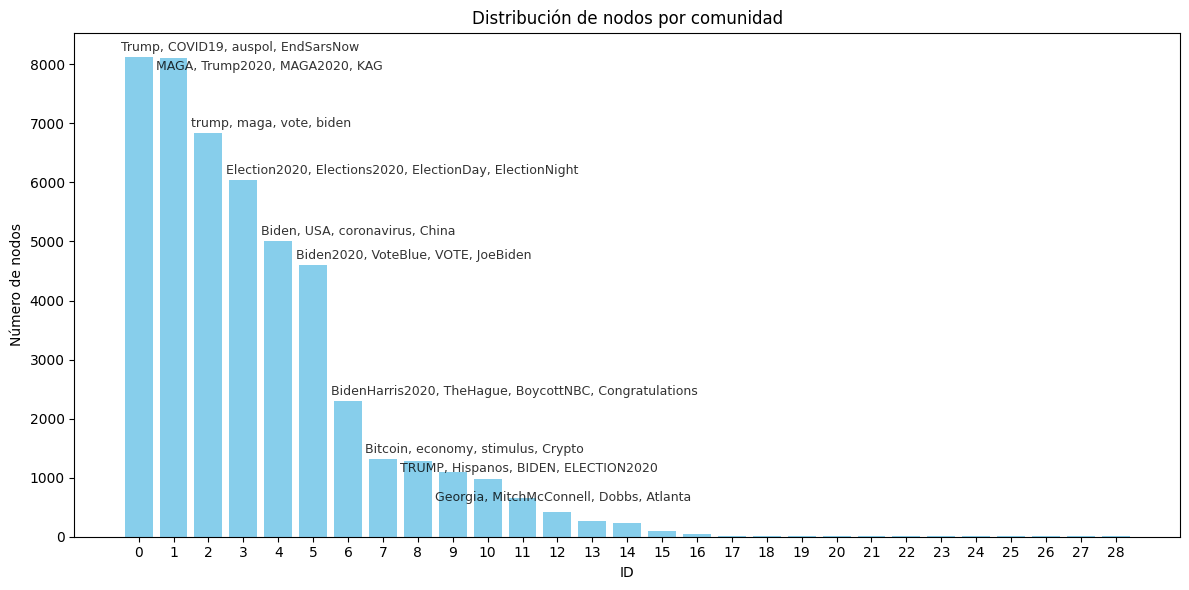

In [27]:
df_nodes = pd.DataFrame.from_dict(dict(G_coms.nodes(data=True)), orient='index')
df_nodes.index.name = 'community_id'
df_nodes.reset_index(inplace=True)
df_nodes = df_nodes.sort_values('community_id')
df_nodes['num_tweets'] = pd.to_numeric(df_nodes['num_tweets'])

x = range(len(df_nodes))
y = df_nodes['size']
labels = df_nodes['community_id'].astype(str)

plt.figure(figsize=(12,6))
bars = plt.bar(x, y, color='skyblue')
plt.xticks(x, labels)
plt.xlabel("ID")
plt.ylabel("Número de nodos")
plt.title("Distribución de nodos por comunidad")

occupied_y = []  

for i, (bar_height, top_nodes) in enumerate(zip(df_nodes['size'], df_nodes['top_10_nodes'])):
    if bar_height > 1000 and top_nodes:
        text = ", ".join(top_nodes[:4])
        y_pos = bar_height  

        while any(abs(y_pos - oy) < 300 for oy in occupied_y):
            y_pos -= 300

        occupied_y.append(y_pos) 

        plt.text(
            x=i -0.5,
            y=y_pos+50,
            s=text,
            fontsize=9,
            ha='left',
            va='bottom',
            rotation=0,
            color='black',
            alpha=0.8
        )

plt.tight_layout()
plt.show()


### Tweets por comunidad

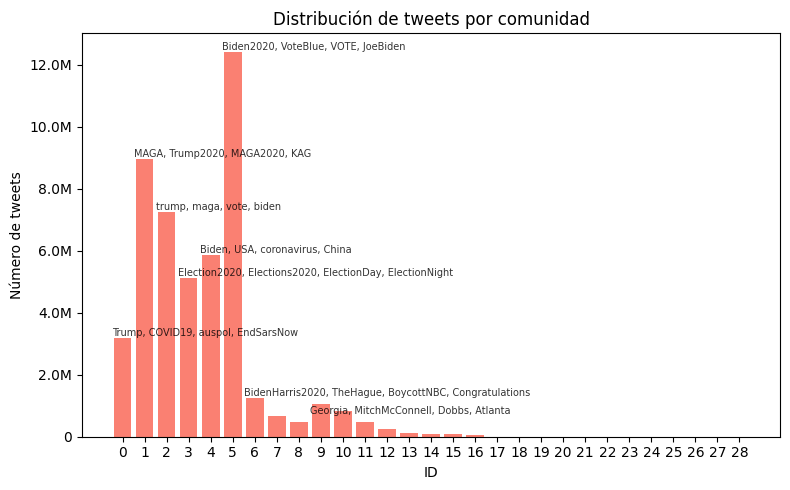

In [28]:
labels = df_nodes['community_id'].astype(str)
x = range(len(df_nodes))
y = df_nodes['num_tweets']

plt.figure(figsize=(8,5))
plt.bar(x, y, color='salmon')
plt.xticks(x, labels)
plt.xlabel("ID")
plt.ylabel("Número de tweets")
plt.title("Distribución de tweets por comunidad")
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda val, pos: format_number(val)))

occupied_y = []  

for i, (bar_height, top_nodes) in enumerate(zip(y, df_nodes['top_10_nodes'])):
    if bar_height > 1_000_000 and top_nodes:  
        text = ", ".join(top_nodes[:4])
        y_pos = bar_height  

        while any(abs(y_pos - oy) < max(y)*0.03 for oy in occupied_y):
            y_pos -= max(y)*0.03

        occupied_y.append(y_pos)  

        plt.text(
            x=i -0.5,
            y=y_pos,
            s=text,
            fontsize=7,
            ha='left',
            va='bottom',
            rotation=0,
            color='black',
            alpha=0.8
        )

plt.tight_layout()
plt.show()


### Tweets vs nodos

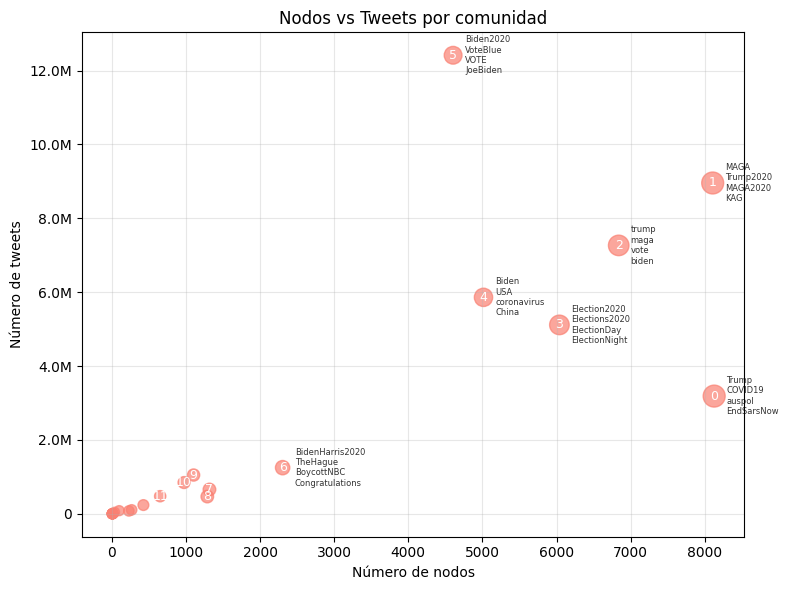

In [29]:
x = df_nodes['size']
y = df_nodes['num_tweets']
labels = df_nodes['community_id'].astype(str)
point_sizes = [50 + 200*(val - min(x))/(max(x)-min(x)+1e-6) for val in x]

plt.figure(figsize=(8,6))
plt.scatter(x, y, s=point_sizes, c='salmon', alpha=0.7)

for xi, yi, label, size, top_nodes in zip(x, y, labels, df_nodes['size'], df_nodes['top_10_nodes']):
    if size > 500:
        plt.text(xi, yi, label, fontsize=9, ha='center', va='center', c="white")
    if size > 2000:
        text = "\n".join(top_nodes[:4])
        offset = 0.02 * max(x)  
        plt.text(x=xi + offset, y=yi, s=text, fontsize=6, ha='left', va='center', color='black', alpha=0.8)

plt.xlabel("Número de nodos")
plt.ylabel("Número de tweets")
plt.title("Nodos vs Tweets por comunidad")
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda val, pos: format_number(val)))

plt.tight_layout()
plt.show()


### Nodos importantes por comunidad

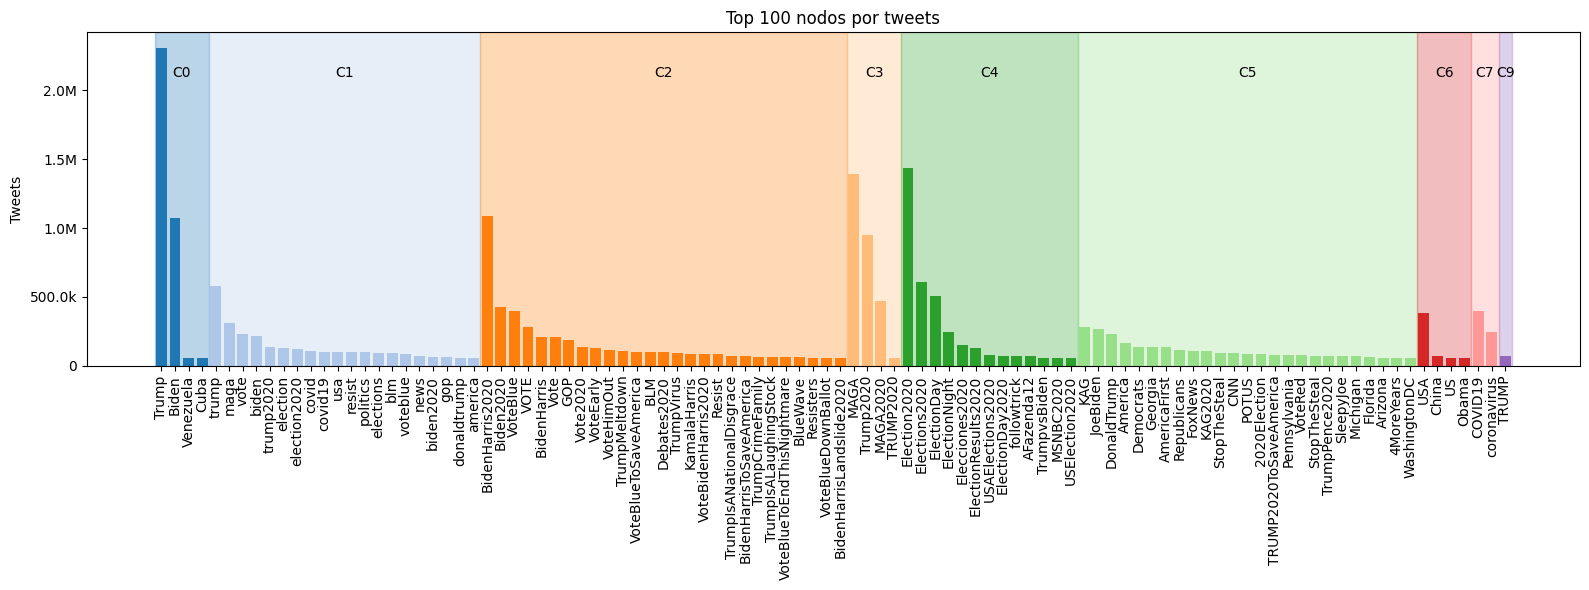

In [153]:
nodes_data = []
for node, data in G.nodes(data=True):
    total_weight = node_total_weight(G, node)
    community = data.get('community', -1)
    nodes_data.append({'node': node, 'weight': total_weight, 'community': community})

df_nodes = pd.DataFrame(nodes_data)

# Tomar los 100 nodos con mayor peso
df_top100 = df_nodes.sort_values('weight', ascending=False).head(100)

# Ordenar por comunidad y dentro de cada comunidad por peso descendente
df_top100 = df_top100.sort_values(['community', 'weight'], ascending=[True, False])
df_top100.reset_index(drop=True, inplace=True)

# Asignar un color a cada comunidad
communities = df_top100['community'].unique()
colors_map = {comm: cm.tab20(i % 20) for i, comm in enumerate(communities)}
bar_colors = df_top100['community'].map(colors_map)

# Barplot
fig, ax = plt.subplots(figsize=(16,6))
bars = ax.bar(df_top100['node'].astype(str), df_top100['weight'], color=bar_colors)
plt.xticks(rotation=90)
ax.set_ylabel("Tweets")
ax.set_title("Top 100 nodos por tweets")

# Dibujar fondo semitransparente por comunidad y texto
last_idx = 0
for comm in communities:
    df_comm = df_top100[df_top100['community'] == comm]
    start_idx = df_comm.index.min()
    end_idx = df_comm.index.max()
    
    # Rectángulo de fondo
    ax.axvspan(start_idx - 0.5, end_idx + 0.5, color=colors_map[comm], alpha=0.3, zorder=-1)
    
    y_pos = max(df_top100['weight']) * 0.9
    mid_idx = (start_idx + end_idx)/2
    ax.text(mid_idx, y_pos, f'C{comm}',
            ha='center', va='bottom', fontsize=10, color='black')

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda val, pos: format_number(val)))

plt.tight_layout()
plt.show()


## 5. ¿Hay nodos centrales?, ¿qué métricas nos ayudan a saberlo? ¿Qué métricas macro nos servirían para explicar la estructura de la red, teniendo en cuenta que son comunidades y no nodos? 


Dependiendo de las distintas métricas de centralidad vemos que unos nodos son centrales u otros. Vamos a aplicar las siguientes métricas:

**Centralidad Degree**: se calcula como el número de aristas de cada no, es la medida de centralidad más simple y no tiene en cuenta la calidad de las conexiones.

In [133]:
deg_cent_com = nx.degree_centrality(G_coms)
nx.set_node_attributes(G_coms, deg_cent_com, name='degree_centrality')

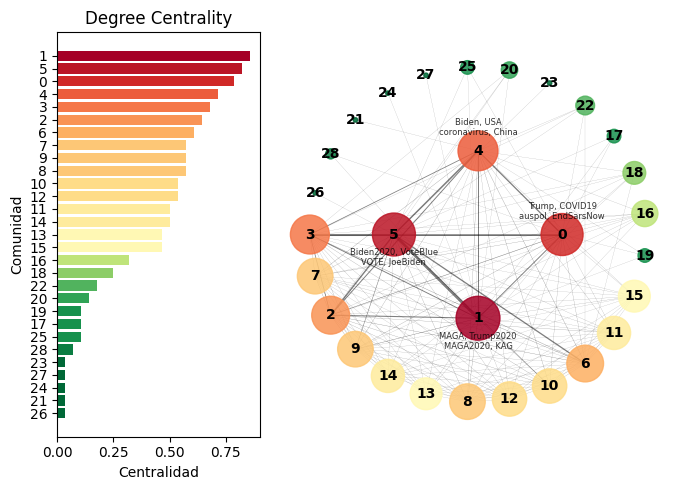

In [110]:
grafica_centralidad(G_coms, "degree_centrality", 0.7, 0.7)

**Centralidad PageRank**: la probabilidad de que un caminante aleatorio visite cada nodo, si tiene en cuenta la calidad de las conexiones. Normalmente se aplica a grafos dirigidos aunque con nx se aplica directamente simulando que todas las aristas son bidireccionales. 

In [ ]:
pagerank_com = nx.pagerank(G_coms, alpha=0.85, weight='weight')
nx.set_node_attributes(G_coms, pagerank_com, name='pagerank_centrality')

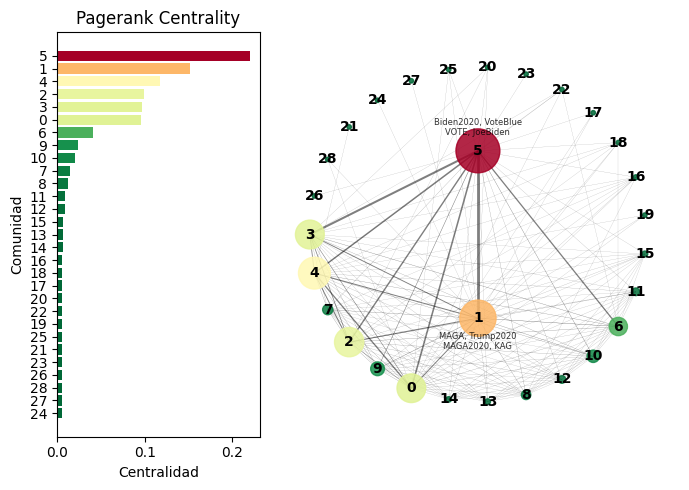

In [114]:
grafica_centralidad(G_coms, "pagerank_centrality", 0.15, 0.15)

**Centralidad Betweenness**: se calcula como el número de caminos mínimos que pasan por un nodo, los nodos con betweenness alto son importantes porque hacen de pegamento en la red.

In [ ]:
betw_cent = nx.betweenness_centrality(G_coms, weight='weight', normalized=True)
nx.set_node_attributes(G_coms, betw_cent, name='betweenness_centrality')

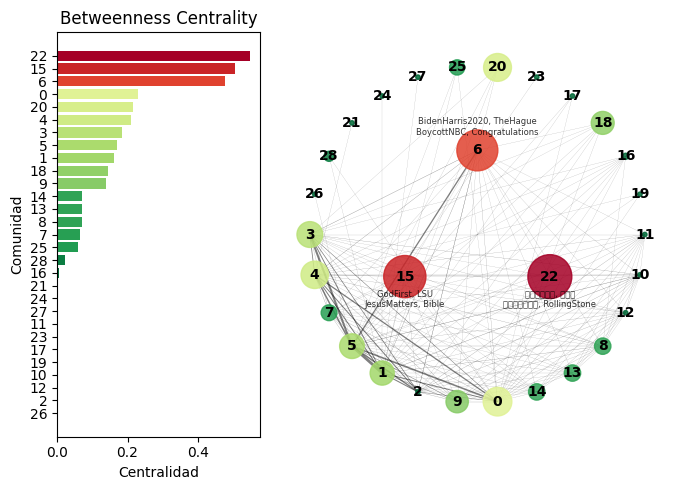

In [115]:
grafica_centralidad(G_coms, "betweenness_centrality", 0.4, 0.4)

**Centralidad Closeness**: la suma de las distancias más cortas de ese nodo a todos los demás nodos, los nodos con closeness alto pueden alcanzar los demás nodos en pocos pasos.

In [ ]:
close_cent = nx.closeness_centrality(G_coms, distance='weight')
nx.set_node_attributes(G_coms, close_cent, name='closeness_centrality')

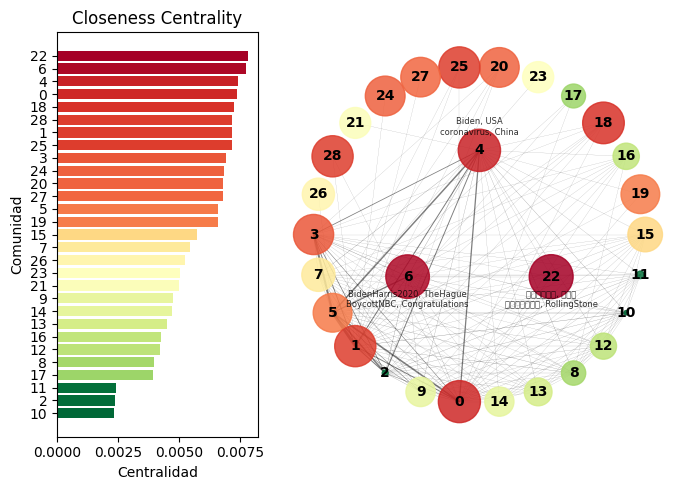

In [116]:
grafica_centralidad(G_coms, "closeness_centrality", 0.0074, 0.0074) 

**K-shell**: evalúa la estructura jerárquica de una red. Identifica nodos que pertenecen a distintas capas dentro de la red. Si el k-shell es alto es que el nodo pertenece a una capa principal (central).

In [ ]:
core_numbers = nx.core_number(G_coms)
nx.set_node_attributes(G_coms, core_numbers, name='k_shell')

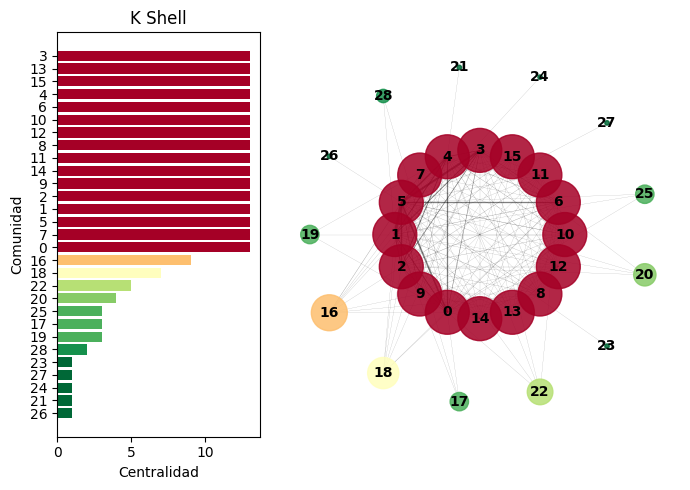

In [118]:
grafica_centralidad(G_coms, "k_shell", 10, 20) 

**Clustering coefficient**: evalúa la estructura de la vecindad del nodo, mide la proporción de triángulos que hay entre los vecinos del nodo. Si es alto significa que la vecindad es robusta. 

In [ ]:
clustering = nx.clustering(G_coms, weight='weight')
nx.set_node_attributes(G_coms, clustering, name='clustering_coefficient')

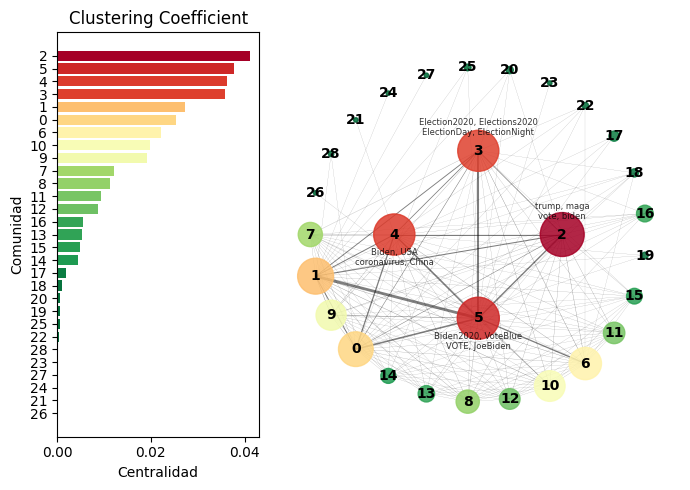

In [119]:
grafica_centralidad(G_coms, "clustering_coefficient", 0.03, 0.03) 

A continuación intentamos representar los valores de las diferentes centralidades de manera conjunta para todas las comunidades. Vemos que las comunidades grandes (menores IDs) suelen ser las más centrales según todas las métricas. Muchas de las comunidades tienen un closeness alto (las comunidades están muy interconectadas, no hay caminos muy largos entre varias comunidades), y se ve bastante variación en betweenness (aunque las comunidades estén bien conectadas entre si, hay ciertos nodos que habilitan muchos de estos caminos cortos entre comunidades que no están directamente conectadas).

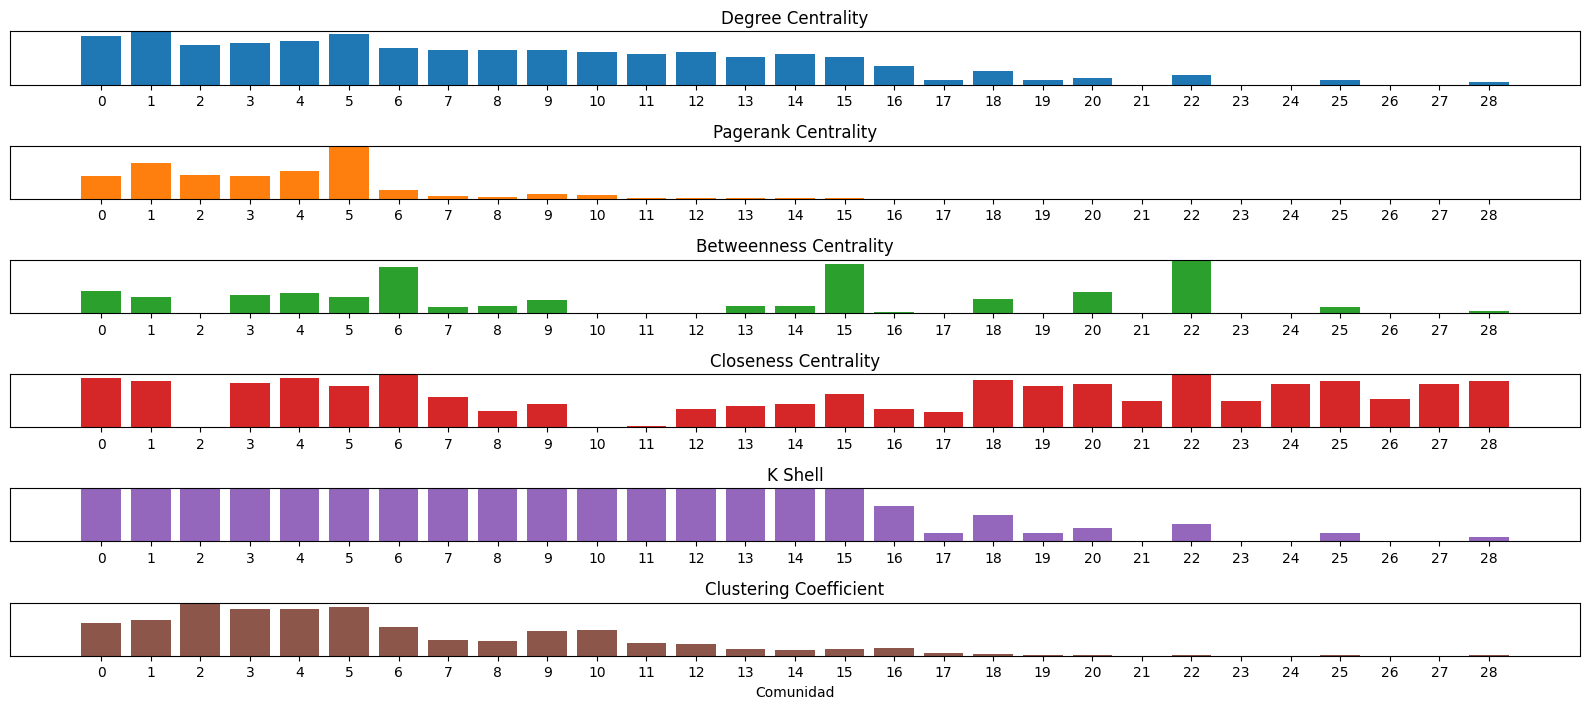

In [132]:
centrality_cols = ["degree_centrality", "pagerank_centrality", "betweenness_centrality",
    "closeness_centrality", "k_shell", "clustering_coefficient"]

df_attrs = pd.DataFrame.from_dict(dict(G_coms.nodes(data=True)), orient='index')
df_attrs.index.name = 'community_id'
df_attrs = df_attrs.sort_index()

communities = df_attrs.index.tolist()
x = np.arange(len(communities))

# Paleta automática
cmap = plt.get_cmap("tab10")
colors = {cent: cmap(i % cmap.N) for i, cent in enumerate(centrality_cols)}

fig, axes = plt.subplots(nrows=len(centrality_cols), ncols=1, figsize=(16, 1.2 * len(centrality_cols)),
    sharex=False)

if len(centrality_cols) == 1:
    axes = [axes]

for ax, cent in zip(axes, centrality_cols):
    vals = df_attrs[cent].values

    vmin, vmax = vals.min(), vals.max()
    if vmax == vmin:
        vals_norm = np.ones_like(vals) * 0.5
    else:
        vals_norm = (vals - vmin) / (vmax - vmin)

    ax.bar(x, vals_norm, color=colors[cent])
    ax.set_title(cent.replace("_", " ").title(), loc="center")
    ax.set_ylim(0, 1)

    ax.set_xticks(x)
    ax.set_xticklabels(communities)
    ax.set_yticks([])
    ax.set_ylabel("")

axes[-1].set_xlabel("Comunidad")

plt.tight_layout()
plt.show()


Dado que el grafo analizado a este nivel está compuesto por comunidades y no por nodos individuales, las métricas de centralidad pasan a tener una interpretación macroestructural. Métricas como degree, PageRank o eigenvector centrality permiten identificar comunidades que actúan como hubs inter-comunitarios o que están conectadas con otras comunidades relevantes. Por su parte, la betweenness centrality señala comunidades puente que canalizan gran parte de los caminos entre bloques temáticos distintos, mientras que la closeness centrality informa sobre la cohesión global del sistema de comunidades.

## 6. ¿Merece la pena hacer comunidades solapadas o no solapadas?

Las comunidades no solapadas ayudan a resumir la información y a tener una visualización más clara, aunque en este caso creemos que sería útil hacer comunidades solapadas por varias razones. 

La principal de ellas es que vemos en varias comunidades hashtags generales que podrían pertenecer por su significado semántico o la persona a la que representan a diferentes comunidades y hemos tenido que restringirlos únicamente a una. Además, varios hashtags pueden participar en contextos diferentes (#VOTE seguido de un hashtag de candidatos distintos) o pueden ser puentes. En el ejecicio anterior hemos visto una closeness alta que sugiere mucha interconexión temática.

Por ello, ambas opciones tienen sentido en distintas aplicaciones y ejemplos, incluso dentro del grafo con el que estamos trabajando ahora mismo.


## 7. ¿Si visualizamos la/s comunidad/es más grandes y las más pequeñas; que se ve, que nos dice esa representación? 

Por ejemplo, viendo el grafo completo vemos que las comunidades pequeñas no están relacionadas entre ellas:

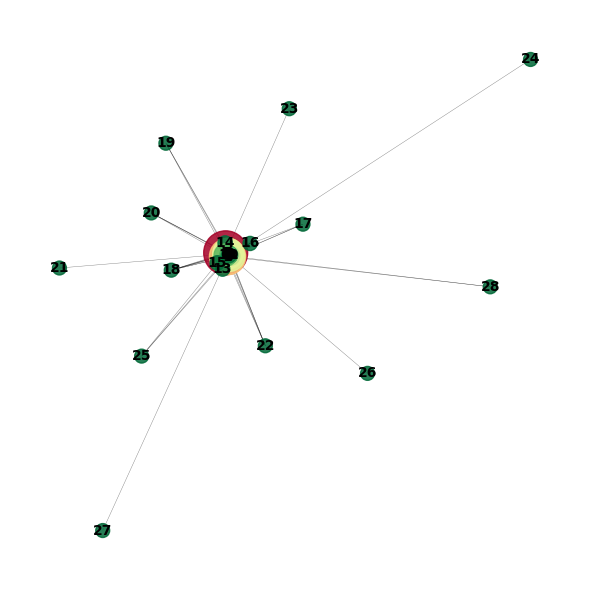

In [144]:
pos = nx.spring_layout(G_coms)
node_sizes = tamaño_nodos(G_coms, min_size=100, max_size=1000)
weights = [node_total_weight(G_coms, n) for n in G_coms.nodes()]
norm = mcolors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = plt.cm.RdYlGn_r
node_colors = [cmap(norm(w)) for w in weights]
edge_widths=tamaño_aristas(G_coms, min_width=0.3, max_width=2)

plt.figure(figsize=(6, 6))
nx.draw_networkx_nodes(G_coms, pos,node_size=node_sizes,node_color=node_colors,alpha=0.85)
nx.draw_networkx_edges(G_coms, pos,width=edge_widths,alpha=0.5)
nx.draw_networkx_labels(G_coms,pos,labels={n: n for n in G_coms.nodes}, font_size=10,font_weight="bold")
plt.axis("off")
plt.tight_layout()
plt.show()


Y si restringimos la visualización solo a las comunidades con más de 100 nodos, vemos que estas si que están muy unidas entre sí. 

Esto, como ya habíamos mencionado antes, se debe a que a la hora de generar comunidades hay hashtags que se han utilizado muy pocas veces pero que existen en los datos y acaban generando comunidades "ruidosas", ya que no tienen mucha presencia ni muchos tweets, y son pocos. Dado que estos hashtags se han usado (pocas veces) con otros hashtags populares, y no con otros hashtags raros, se forman estas comunidades que no pueden englobarlos a todos juntos ya que no están conectados.

Por lo que, los hashtags generales se utilizan mucho, y con muchos distintos, y los especificos y nicho se agrupan entre los pocos con los que han coincidido.

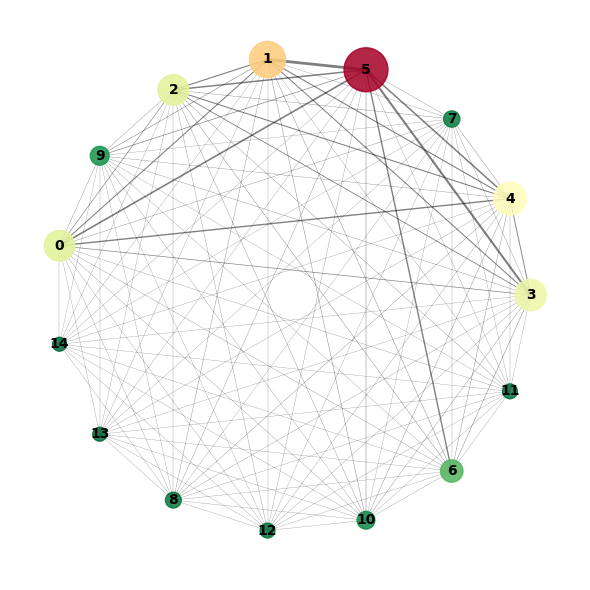

In [146]:
filtered_nodes = [n for n, data in G_coms.nodes(data=True) if data["size"] > 100]
G_filtered = G_coms.subgraph(filtered_nodes).copy()

pos = nx.circular_layout(G_filtered)
node_sizes = tamaño_nodos(G_filtered, min_size=100, max_size=1000)
weights = [node_total_weight(G_filtered, n) for n in G_filtered.nodes()]
norm = mcolors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = plt.cm.RdYlGn_r
node_colors = [cmap(norm(w)) for w in weights]
edge_widths=tamaño_aristas(G_filtered, min_width=0.2, max_width=2)

plt.figure(figsize=(6, 6))
nx.draw_networkx_nodes(G_filtered, pos,node_size=node_sizes,node_color=node_colors,alpha=0.85)
nx.draw_networkx_edges(G_filtered, pos,width=edge_widths,alpha=0.5)
nx.draw_networkx_labels(G_filtered,pos,labels={n: n for n in G_filtered.nodes}, font_size=10,font_weight="bold")
plt.axis("off")
plt.tight_layout()
plt.show()


## 8. Describe los contenidos de cada comunidad. ¿Es posible, aunque sea intuitivamente, caracterizar una comunidad en función de sus hashtags más importantes? 


Imprimimos los 10 nodos con más tweets de cada comunidad:

In [ ]:
for idx in range(num_communities):
    comm_i = community_df.iloc[idx]
    print(f"\nComunidad {idx}:")
    print(", ".join(comm_i['top_10_nodes'][:10]))



Comunidad 0:
Trump, COVID19, auspol, EndSarsNow, wednesdaythought, EndPoliceBrutalityinNigeraNOW, humantraffickingawareness, HitRefresh, RbyPoll, FelizLunes

Comunidad 1:
MAGA, Trump2020, MAGA2020, KAG, America, Democrats, AmericaFirst, KAG2020, StopTheSteal, POTUS

Comunidad 2:
trump, maga, vote, biden, trump2020, election, election2020, covid, covid19, usa

Comunidad 3:
Election2020, Elections2020, ElectionDay, ElectionNight, Elecciones2020, USAElections2020, ElectionDay2020, followtrick, AFazenda12, TrumpvsBiden

Comunidad 4:
Biden, USA, coronavirus, China, Venezuela, Cuba, US, Obama, Coronavirus, Mexico

Comunidad 5:
Biden2020, VoteBlue, VOTE, JoeBiden, DonaldTrump, BidenHarris, Vote, GOP, Vote2020, ElectionResults2020

Comunidad 6:
BidenHarris2020, TheHague, BoycottNBC, Congratulations, DV2020, DV2021, Immigrant, NBCBlackout, TeamPetty4Joe, ToddlerInChief

Comunidad 7:
Bitcoin, economy, stimulus, Crypto, bitcoin, dolar, money, Giveaway, stocks, forex

Comunidad 8:
TRUMP, Hispanos

Como podemos ver, el top 10 de nodos más importantes nos da información relevante sobre la comunidad. Hay comunidades que utilizan términos en su mayoría relacionados con el partido republicano, otras con el partido demócrata, términos generales de las elecciones, o temas concretos relacionados con la economía, países, estados y más. Si quisiese realizarse un proceso para obtener las temáticas de las comunidades podría usarse un LLM, incluir en el prompt el top K nodos más importantes y pedirle una breve descripción que los englobe. 

## 9. Finalmente, utilizando técnicas de predicción de aristas, ¿qué comunidades tienen más probabilidades de estar unidas? Habiendo descrito dichas comunidades previamente, ¿tienen sentido estas predicciones? 
